In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from google.colab import drive
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
num_epochs = 60
learning_rate = 0.001
batch_size = 32
use_cbam = False

In [5]:
if use_cbam:
  results_filename = '/content/gdrive/My Drive/Deep Learning/Project/Results_CBAM.csv'
  models_dirname = '/content/gdrive/My Drive/Deep Learning/Project/Models/CBAM'
else:
  results_filename = '/content/gdrive/My Drive/Deep Learning/Project/Results_NO_CBAM.csv'
  models_dirname = '/content/gdrive/My Drive/Deep Learning/Project/Models/NO_CBAM'

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


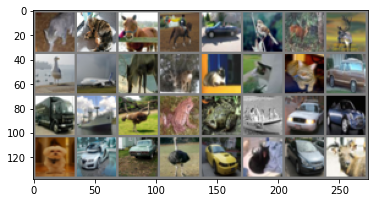


  cat   cat horse horse   car  bird  deer  deer  bird plane  deer  deer   cat   cat   cat   car truck  ship  bird  frog  frog  ship   car   car   dog   car   car  bird   car   cat   car  deer


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1, groups=1)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out)
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        x_out = self.SpatialGate(x_out)
        return x_out

In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, use_cbam):
        self.use_cbam = use_cbam
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam = self.use_cbam))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam = self.use_cbam))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [10]:
net = ResNet(BasicBlock, [3, 4, 6, 3], len(classes), use_cbam=use_cbam)
net.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print("Model Initialised")

Model Initialised


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [12]:
results = pd.DataFrame(columns=["Epoch", "Trainset Loss", "Testset Loss", "Trainset Accuracy", "Testset Accuracy", "Trainset Classwise Accuracy", "Testset Classwise Accuracy"])

In [13]:
for epoch in range(num_epochs):

  running_loss = 0.0
  total = 0
  correct = 0
  classwise_correct = {key: 0 for key in classes}
  classwise_total = {key: 0 for key in classes}

  print(f"\nEpoch {epoch+1}\n")

  print("\nTraining\n")

  for data in tqdm(trainloader):
      inputs, labels = data
      if torch.cuda.is_available():
          inputs, labels = inputs.cuda(), labels.cuda()

      optimizer.zero_grad()

      outputs = net(inputs)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      for i in range(labels.size(0)):
        label = classes[labels[i].item()]
        classwise_correct[label] += (predicted[i].item() == labels[i].item())
        classwise_total[label] += 1

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
  
  train_loss = running_loss
  train_accuracy = (correct/total)*100
  train_classwise_accuracy = {key: ((classwise_correct[key]/classwise_total[key])*100) for key in classes}

  print(f"\nLoss = {train_loss}, Accuracy = {train_accuracy}\n")
  print(f"\nClasswise Accuracy = {train_classwise_accuracy}\n")

  running_loss = 0.0
  total = 0
  correct = 0
  classwise_correct = {key: 0 for key in classes}
  classwise_total = {key: 0 for key in classes}

  print("\nTesting\n")

  with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
          label = classes[labels[i].item()]
          classwise_correct[label] += (predicted[i].item() == labels[i].item())
          classwise_total[label] += 1

        loss = criterion(outputs, labels)
        running_loss += loss.item()
  
  test_loss = running_loss
  test_accuracy = (correct/total)*100
  test_classwise_accuracy = {key: ((classwise_correct[key]/classwise_total[key])*100) for key in classes}

  print(f"\nLoss = {test_loss}, Accuracy = {test_accuracy}\n")
  print(f"\nClasswise Accuracy = {test_classwise_accuracy}\n")

  results = results.append({"Epoch": (epoch+1), \
                            "Trainset Loss": train_loss, "Testset Loss": test_loss, \
                            "Trainset Accuracy": train_accuracy, "Testset Accuracy": test_accuracy, \
                            "Trainset Classwise Accuracy": train_classwise_accuracy, "Testset Classwise Accuracy": test_classwise_accuracy}, \
                           ignore_index=True)
  
  torch.save(net.state_dict(), models_dirname+f"/{epoch+1}.pth")
  results.to_csv(results_filename)


Epoch 1


Training





Loss = 2471.363452076912, Accuracy = 42.403999999999996


Classwise Accuracy = {'plane': 46.7, 'car': 54.50000000000001, 'bird': 26.36, 'cat': 28.78, 'deer': 30.84, 'dog': 37.580000000000005, 'frog': 49.059999999999995, 'horse': 49.64, 'ship': 51.88, 'truck': 48.699999999999996}


Testing





Loss = 404.797300696373, Accuracy = 52.96999999999999


Classwise Accuracy = {'plane': 55.1, 'car': 74.5, 'bird': 31.5, 'cat': 38.3, 'deer': 30.7, 'dog': 44.0, 'frog': 72.39999999999999, 'horse': 68.4, 'ship': 61.9, 'truck': 52.900000000000006}


Epoch 2


Training





Loss = 1773.6698532104492, Accuracy = 59.628


Classwise Accuracy = {'plane': 62.760000000000005, 'car': 72.96000000000001, 'bird': 46.52, 'cat': 41.4, 'deer': 47.86, 'dog': 51.1, 'frog': 68.89999999999999, 'horse': 66.34, 'ship': 71.86, 'truck': 66.58}


Testing





Loss = 331.0375662446022, Accuracy = 62.519999999999996


Classwise Accuracy = {'plane': 67.30000000000001, 'car': 82.1, 'bird': 54.1, 'cat': 41.5, 'deer': 39.5, 'dog': 54.300000000000004, 'frog': 81.8, 'horse': 65.5, 'ship': 78.2, 'truck': 60.9}


Epoch 3


Training





Loss = 1363.7912538945675, Accuracy = 69.266


Classwise Accuracy = {'plane': 72.72, 'car': 81.54, 'bird': 57.879999999999995, 'cat': 49.74, 'deer': 61.94, 'dog': 59.08, 'frog': 76.84, 'horse': 74.56, 'ship': 81.08, 'truck': 77.28}


Testing





Loss = 295.2868641912937, Accuracy = 67.22


Classwise Accuracy = {'plane': 66.4, 'car': 82.8, 'bird': 62.9, 'cat': 41.699999999999996, 'deer': 64.9, 'dog': 55.400000000000006, 'frog': 72.6, 'horse': 74.9, 'ship': 78.9, 'truck': 71.7}


Epoch 4


Training





Loss = 1031.5253585129976, Accuracy = 76.854


Classwise Accuracy = {'plane': 79.02, 'car': 87.42, 'bird': 68.14, 'cat': 60.34, 'deer': 71.7, 'dog': 67.42, 'frog': 82.38, 'horse': 80.66, 'ship': 86.82, 'truck': 84.64}


Testing





Loss = 275.5983010828495, Accuracy = 69.8


Classwise Accuracy = {'plane': 76.8, 'car': 73.4, 'bird': 50.6, 'cat': 56.89999999999999, 'deer': 67.4, 'dog': 55.400000000000006, 'frog': 78.5, 'horse': 71.6, 'ship': 84.3, 'truck': 83.1}


Epoch 5


Training





Loss = 750.3650308996439, Accuracy = 83.27799999999999


Classwise Accuracy = {'plane': 85.02, 'car': 91.52, 'bird': 76.22, 'cat': 70.67999999999999, 'deer': 79.9, 'dog': 75.08, 'frog': 87.4, 'horse': 87.03999999999999, 'ship': 90.66, 'truck': 89.25999999999999}


Testing





Loss = 293.2332230210304, Accuracy = 70.03


Classwise Accuracy = {'plane': 70.7, 'car': 85.1, 'bird': 56.2, 'cat': 53.7, 'deer': 71.8, 'dog': 53.7, 'frog': 79.0, 'horse': 67.80000000000001, 'ship': 82.39999999999999, 'truck': 79.9}


Epoch 6


Training





Loss = 516.5690226070583, Accuracy = 88.626


Classwise Accuracy = {'plane': 90.06, 'car': 94.26, 'bird': 84.34, 'cat': 79.28, 'deer': 86.61999999999999, 'dog': 83.14, 'frog': 91.10000000000001, 'horse': 90.84, 'ship': 93.34, 'truck': 93.28}


Testing





Loss = 308.80795055627823, Accuracy = 69.52000000000001


Classwise Accuracy = {'plane': 79.4, 'car': 85.5, 'bird': 52.0, 'cat': 51.6, 'deer': 66.4, 'dog': 61.5, 'frog': 72.5, 'horse': 71.1, 'ship': 77.5, 'truck': 77.7}


Epoch 7


Training





Loss = 347.0523063633591, Accuracy = 92.456


Classwise Accuracy = {'plane': 93.28, 'car': 95.82000000000001, 'bird': 89.92, 'cat': 87.22, 'deer': 90.86, 'dog': 88.96, 'frog': 93.74, 'horse': 94.32000000000001, 'ship': 95.26, 'truck': 95.17999999999999}


Testing





Loss = 332.797218054533, Accuracy = 70.08


Classwise Accuracy = {'plane': 74.1, 'car': 85.0, 'bird': 52.5, 'cat': 58.599999999999994, 'deer': 63.3, 'dog': 63.9, 'frog': 74.5, 'horse': 68.7, 'ship': 82.5, 'truck': 77.7}


Epoch 8


Training





Loss = 254.5638565896079, Accuracy = 94.294


Classwise Accuracy = {'plane': 94.58, 'car': 96.78, 'bird': 92.14, 'cat': 90.58, 'deer': 93.38, 'dog': 91.88, 'frog': 95.39999999999999, 'horse': 95.54, 'ship': 96.39999999999999, 'truck': 96.26}


Testing





Loss = 338.4157654941082, Accuracy = 71.07


Classwise Accuracy = {'plane': 77.10000000000001, 'car': 86.7, 'bird': 61.4, 'cat': 44.5, 'deer': 65.2, 'dog': 62.6, 'frog': 75.1, 'horse': 77.60000000000001, 'ship': 83.5, 'truck': 77.0}


Epoch 9


Training





Loss = 190.68453424749896, Accuracy = 95.812


Classwise Accuracy = {'plane': 96.32, 'car': 97.58, 'bird': 94.38, 'cat': 92.66, 'deer': 95.24000000000001, 'dog': 93.94, 'frog': 96.34, 'horse': 97.06, 'ship': 97.48, 'truck': 97.11999999999999}


Testing





Loss = 365.0249957740307, Accuracy = 71.50999999999999


Classwise Accuracy = {'plane': 72.39999999999999, 'car': 81.39999999999999, 'bird': 65.2, 'cat': 39.300000000000004, 'deer': 59.599999999999994, 'dog': 68.60000000000001, 'frog': 84.0, 'horse': 78.3, 'ship': 82.6, 'truck': 83.7}


Epoch 10


Training





Loss = 134.99370905500837, Accuracy = 97.062


Classwise Accuracy = {'plane': 97.39999999999999, 'car': 98.22, 'bird': 95.88, 'cat': 95.1, 'deer': 96.74000000000001, 'dog': 96.02000000000001, 'frog': 97.6, 'horse': 97.5, 'ship': 97.96000000000001, 'truck': 98.2}


Testing





Loss = 374.53703060746193, Accuracy = 71.08


Classwise Accuracy = {'plane': 72.2, 'car': 83.0, 'bird': 68.5, 'cat': 52.1, 'deer': 60.199999999999996, 'dog': 47.5, 'frog': 77.9, 'horse': 78.3, 'ship': 88.4, 'truck': 82.69999999999999}


Epoch 11


Training





Loss = 122.86834551254287, Accuracy = 97.392


Classwise Accuracy = {'plane': 97.58, 'car': 98.74000000000001, 'bird': 96.32, 'cat': 95.46, 'deer': 97.14, 'dog': 96.08, 'frog': 98.14, 'horse': 97.92, 'ship': 98.28, 'truck': 98.26}


Testing





Loss = 379.2533588260412, Accuracy = 71.63000000000001


Classwise Accuracy = {'plane': 77.9, 'car': 84.7, 'bird': 62.9, 'cat': 42.6, 'deer': 60.3, 'dog': 60.3, 'frog': 84.8, 'horse': 79.3, 'ship': 81.5, 'truck': 82.0}


Epoch 12


Training





Loss = 105.18604076141492, Accuracy = 97.726


Classwise Accuracy = {'plane': 97.66, 'car': 98.72, 'bird': 96.94, 'cat': 96.44, 'deer': 97.46000000000001, 'dog': 96.82, 'frog': 98.22, 'horse': 98.32, 'ship': 98.16, 'truck': 98.52}


Testing





Loss = 386.35598278045654, Accuracy = 72.37


Classwise Accuracy = {'plane': 81.89999999999999, 'car': 83.7, 'bird': 60.699999999999996, 'cat': 54.2, 'deer': 66.60000000000001, 'dog': 56.699999999999996, 'frog': 79.3, 'horse': 76.2, 'ship': 80.2, 'truck': 84.2}


Epoch 13


Training





Loss = 89.99734099884517, Accuracy = 98.002


Classwise Accuracy = {'plane': 98.3, 'car': 98.82, 'bird': 97.44, 'cat': 96.64, 'deer': 97.6, 'dog': 97.14, 'frog': 98.4, 'horse': 98.2, 'ship': 98.72, 'truck': 98.76}


Testing





Loss = 398.1825680434704, Accuracy = 71.97


Classwise Accuracy = {'plane': 81.0, 'car': 83.6, 'bird': 59.699999999999996, 'cat': 48.0, 'deer': 67.2, 'dog': 66.5, 'frog': 77.5, 'horse': 74.6, 'ship': 78.5, 'truck': 83.1}


Epoch 14


Training





Loss = 75.447232398903, Accuracy = 98.414


Classwise Accuracy = {'plane': 98.44000000000001, 'car': 99.11999999999999, 'bird': 97.52, 'cat': 97.56, 'deer': 98.4, 'dog': 97.8, 'frog': 98.7, 'horse': 98.7, 'ship': 98.83999999999999, 'truck': 99.06}


Testing





Loss = 387.17183773219585, Accuracy = 73.61


Classwise Accuracy = {'plane': 77.10000000000001, 'car': 86.5, 'bird': 64.1, 'cat': 49.2, 'deer': 66.60000000000001, 'dog': 60.3, 'frog': 83.39999999999999, 'horse': 79.7, 'ship': 85.8, 'truck': 83.39999999999999}


Epoch 15


Training





Loss = 60.8013044243562, Accuracy = 98.77


Classwise Accuracy = {'plane': 98.82, 'car': 99.16, 'bird': 98.34, 'cat': 98.14, 'deer': 98.48, 'dog': 98.44000000000001, 'frog': 99.06, 'horse': 99.14, 'ship': 99.03999999999999, 'truck': 99.08}


Testing





Loss = 404.36368295550346, Accuracy = 72.86


Classwise Accuracy = {'plane': 81.69999999999999, 'car': 87.7, 'bird': 60.4, 'cat': 50.6, 'deer': 71.89999999999999, 'dog': 60.699999999999996, 'frog': 79.7, 'horse': 74.9, 'ship': 80.80000000000001, 'truck': 80.2}


Epoch 16


Training





Loss = 52.21084806887666, Accuracy = 98.92


Classwise Accuracy = {'plane': 98.98, 'car': 99.53999999999999, 'bird': 98.64, 'cat': 98.1, 'deer': 98.68, 'dog': 98.6, 'frog': 98.98, 'horse': 99.14, 'ship': 99.33999999999999, 'truck': 99.2}


Testing





Loss = 403.73379349708557, Accuracy = 72.98


Classwise Accuracy = {'plane': 77.8, 'car': 88.2, 'bird': 61.3, 'cat': 53.900000000000006, 'deer': 67.2, 'dog': 62.9, 'frog': 78.60000000000001, 'horse': 76.2, 'ship': 83.5, 'truck': 80.2}


Epoch 17


Training





Loss = 35.243984731379896, Accuracy = 99.29599999999999


Classwise Accuracy = {'plane': 99.38, 'car': 99.6, 'bird': 99.11999999999999, 'cat': 98.92, 'deer': 99.1, 'dog': 99.2, 'frog': 99.58, 'horse': 99.26, 'ship': 99.44, 'truck': 99.36}


Testing





Loss = 401.33889934420586, Accuracy = 73.13


Classwise Accuracy = {'plane': 80.4, 'car': 87.7, 'bird': 64.9, 'cat': 53.300000000000004, 'deer': 64.5, 'dog': 63.6, 'frog': 78.60000000000001, 'horse': 75.6, 'ship': 81.89999999999999, 'truck': 80.80000000000001}


Epoch 18


Training





Loss = 36.91783222835511, Accuracy = 99.264


Classwise Accuracy = {'plane': 99.28, 'car': 99.56, 'bird': 98.78, 'cat': 99.02, 'deer': 99.06, 'dog': 99.1, 'frog': 99.56, 'horse': 99.33999999999999, 'ship': 99.38, 'truck': 99.56}


Testing





Loss = 404.81198005378246, Accuracy = 73.49


Classwise Accuracy = {'plane': 80.2, 'car': 86.4, 'bird': 65.0, 'cat': 46.2, 'deer': 67.80000000000001, 'dog': 63.3, 'frog': 78.9, 'horse': 77.3, 'ship': 85.0, 'truck': 84.8}


Epoch 19


Training





Loss = 29.952873717615148, Accuracy = 99.388


Classwise Accuracy = {'plane': 99.46000000000001, 'car': 99.78, 'bird': 99.14, 'cat': 98.94, 'deer': 99.22, 'dog': 99.14, 'frog': 99.5, 'horse': 99.4, 'ship': 99.6, 'truck': 99.7}


Testing





Loss = 406.16964849829674, Accuracy = 73.49


Classwise Accuracy = {'plane': 79.10000000000001, 'car': 84.2, 'bird': 56.599999999999994, 'cat': 56.99999999999999, 'deer': 68.4, 'dog': 60.099999999999994, 'frog': 83.6, 'horse': 74.9, 'ship': 85.8, 'truck': 85.2}


Epoch 20


Training





Loss = 25.891687292882125, Accuracy = 99.516


Classwise Accuracy = {'plane': 99.56, 'car': 99.58, 'bird': 99.2, 'cat': 99.36, 'deer': 99.38, 'dog': 99.44, 'frog': 99.62, 'horse': 99.58, 'ship': 99.76, 'truck': 99.68}


Testing





Loss = 410.25640474259853, Accuracy = 73.61


Classwise Accuracy = {'plane': 80.5, 'car': 90.60000000000001, 'bird': 63.800000000000004, 'cat': 47.9, 'deer': 71.0, 'dog': 64.7, 'frog': 81.39999999999999, 'horse': 78.3, 'ship': 83.7, 'truck': 74.2}


Epoch 21


Training





Loss = 17.68406912682258, Accuracy = 99.676


Classwise Accuracy = {'plane': 99.7, 'car': 99.82, 'bird': 99.56, 'cat': 99.5, 'deer': 99.68, 'dog': 99.52, 'frog': 99.74, 'horse': 99.74, 'ship': 99.88, 'truck': 99.62}


Testing





Loss = 405.78411054611206, Accuracy = 74.06


Classwise Accuracy = {'plane': 80.30000000000001, 'car': 86.5, 'bird': 58.099999999999994, 'cat': 49.4, 'deer': 71.6, 'dog': 64.9, 'frog': 84.1, 'horse': 78.10000000000001, 'ship': 84.6, 'truck': 83.0}


Epoch 22


Training





Loss = 13.466640941856895, Accuracy = 99.79


Classwise Accuracy = {'plane': 99.9, 'car': 99.86, 'bird': 99.7, 'cat': 99.66000000000001, 'deer': 99.76, 'dog': 99.7, 'frog': 99.82, 'horse': 99.76, 'ship': 99.9, 'truck': 99.83999999999999}


Testing





Loss = 403.18888702988625, Accuracy = 74.02


Classwise Accuracy = {'plane': 76.5, 'car': 87.5, 'bird': 66.2, 'cat': 52.800000000000004, 'deer': 64.3, 'dog': 63.9, 'frog': 82.6, 'horse': 79.60000000000001, 'ship': 85.1, 'truck': 81.69999999999999}


Epoch 23


Training





Loss = 8.094646836063475, Accuracy = 99.89


Classwise Accuracy = {'plane': 99.92, 'car': 100.0, 'bird': 99.82, 'cat': 99.82, 'deer': 99.86, 'dog': 99.88, 'frog': 99.9, 'horse': 99.86, 'ship': 99.88, 'truck': 99.96000000000001}


Testing





Loss = 404.47270515561104, Accuracy = 74.55000000000001


Classwise Accuracy = {'plane': 80.80000000000001, 'car': 88.3, 'bird': 61.6, 'cat': 55.300000000000004, 'deer': 68.8, 'dog': 60.6, 'frog': 81.5, 'horse': 81.8, 'ship': 84.6, 'truck': 82.19999999999999}


Epoch 24


Training





Loss = 8.898549456360342, Accuracy = 99.854


Classwise Accuracy = {'plane': 99.83999999999999, 'car': 99.88, 'bird': 99.94, 'cat': 99.8, 'deer': 99.83999999999999, 'dog': 99.72, 'frog': 99.83999999999999, 'horse': 99.86, 'ship': 99.94, 'truck': 99.88}


Testing





Loss = 407.67470820248127, Accuracy = 74.24


Classwise Accuracy = {'plane': 78.7, 'car': 88.2, 'bird': 63.7, 'cat': 50.5, 'deer': 68.0, 'dog': 65.10000000000001, 'frog': 81.89999999999999, 'horse': 80.2, 'ship': 85.6, 'truck': 80.5}


Epoch 25


Training





Loss = 10.38917020036024, Accuracy = 99.842


Classwise Accuracy = {'plane': 99.86, 'car': 99.98, 'bird': 99.83999999999999, 'cat': 99.74, 'deer': 99.82, 'dog': 99.78, 'frog': 99.86, 'horse': 99.92, 'ship': 99.78, 'truck': 99.83999999999999}


Testing





Loss = 404.0335363447666, Accuracy = 74.77000000000001


Classwise Accuracy = {'plane': 78.3, 'car': 89.7, 'bird': 63.5, 'cat': 51.800000000000004, 'deer': 72.6, 'dog': 62.5, 'frog': 81.89999999999999, 'horse': 79.3, 'ship': 85.6, 'truck': 82.5}


Epoch 26


Training





Loss = 6.134215630845574, Accuracy = 99.91600000000001


Classwise Accuracy = {'plane': 99.94, 'car': 99.96000000000001, 'bird': 99.9, 'cat': 99.76, 'deer': 99.92, 'dog': 99.88, 'frog': 99.94, 'horse': 99.94, 'ship': 99.92, 'truck': 100.0}


Testing





Loss = 395.2245082259178, Accuracy = 74.78


Classwise Accuracy = {'plane': 79.7, 'car': 87.4, 'bird': 63.1, 'cat': 53.2, 'deer': 71.7, 'dog': 60.699999999999996, 'frog': 82.39999999999999, 'horse': 77.5, 'ship': 86.2, 'truck': 85.9}


Epoch 27


Training





Loss = 3.9647213241223653, Accuracy = 99.96000000000001


Classwise Accuracy = {'plane': 99.98, 'car': 99.98, 'bird': 99.94, 'cat': 99.94, 'deer': 99.98, 'dog': 99.98, 'frog': 99.92, 'horse': 99.92, 'ship': 99.98, 'truck': 99.98}


Testing





Loss = 393.91676165163517, Accuracy = 74.98


Classwise Accuracy = {'plane': 79.9, 'car': 87.4, 'bird': 63.5, 'cat': 54.300000000000004, 'deer': 68.89999999999999, 'dog': 64.8, 'frog': 80.80000000000001, 'horse': 78.60000000000001, 'ship': 86.9, 'truck': 84.7}


Epoch 28


Training





Loss = 3.3280802515437244, Accuracy = 99.97399999999999


Classwise Accuracy = {'plane': 99.98, 'car': 100.0, 'bird': 99.96000000000001, 'cat': 99.94, 'deer': 99.98, 'dog': 99.96000000000001, 'frog': 99.98, 'horse': 99.96000000000001, 'ship': 100.0, 'truck': 99.98}


Testing





Loss = 393.8361791372299, Accuracy = 75.22


Classwise Accuracy = {'plane': 81.3, 'car': 87.7, 'bird': 66.3, 'cat': 49.5, 'deer': 69.89999999999999, 'dog': 66.5, 'frog': 82.5, 'horse': 81.8, 'ship': 83.5, 'truck': 83.2}


Epoch 29


Training





Loss = 2.754363269832538, Accuracy = 99.982


Classwise Accuracy = {'plane': 99.98, 'car': 100.0, 'bird': 99.92, 'cat': 99.98, 'deer': 100.0, 'dog': 99.98, 'frog': 99.98, 'horse': 100.0, 'ship': 99.98, 'truck': 100.0}


Testing





Loss = 387.4900534451008, Accuracy = 75.53


Classwise Accuracy = {'plane': 80.4, 'car': 88.6, 'bird': 63.2, 'cat': 54.0, 'deer': 71.8, 'dog': 64.3, 'frog': 84.1, 'horse': 78.9, 'ship': 85.9, 'truck': 84.1}


Epoch 30


Training





Loss = 2.046331517121871, Accuracy = 99.996


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 99.98, 'cat': 100.0, 'deer': 99.98, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 383.52229249477386, Accuracy = 75.38


Classwise Accuracy = {'plane': 79.3, 'car': 88.7, 'bird': 64.60000000000001, 'cat': 52.300000000000004, 'deer': 72.7, 'dog': 63.9, 'frog': 83.0, 'horse': 79.0, 'ship': 86.8, 'truck': 83.5}


Epoch 31


Training





Loss = 1.8678183797928796, Accuracy = 99.994


Classwise Accuracy = {'plane': 100.0, 'car': 99.98, 'bird': 100.0, 'cat': 99.98, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 99.98}


Testing





Loss = 383.49066239595413, Accuracy = 75.52


Classwise Accuracy = {'plane': 80.30000000000001, 'car': 89.5, 'bird': 64.2, 'cat': 56.3, 'deer': 70.6, 'dog': 64.0, 'frog': 82.6, 'horse': 78.9, 'ship': 85.7, 'truck': 83.1}


Epoch 32


Training





Loss = 1.506971824743232, Accuracy = 99.992


Classwise Accuracy = {'plane': 99.96000000000001, 'car': 99.98, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 99.98, 'truck': 100.0}


Testing





Loss = 377.7292187511921, Accuracy = 75.53


Classwise Accuracy = {'plane': 80.5, 'car': 88.6, 'bird': 66.2, 'cat': 51.6, 'deer': 72.7, 'dog': 62.7, 'frog': 82.6, 'horse': 79.0, 'ship': 86.9, 'truck': 84.5}


Epoch 33


Training





Loss = 1.6713042031824443, Accuracy = 99.99


Classwise Accuracy = {'plane': 99.98, 'car': 99.98, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 99.98, 'horse': 99.98, 'ship': 99.98, 'truck': 100.0}


Testing





Loss = 380.17891159653664, Accuracy = 75.66000000000001


Classwise Accuracy = {'plane': 79.9, 'car': 89.9, 'bird': 67.9, 'cat': 54.6, 'deer': 70.89999999999999, 'dog': 62.0, 'frog': 82.89999999999999, 'horse': 78.60000000000001, 'ship': 85.2, 'truck': 84.7}


Epoch 34


Training





Loss = 1.3422498431154963, Accuracy = 99.998


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 99.98, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 375.5887449979782, Accuracy = 75.63


Classwise Accuracy = {'plane': 81.2, 'car': 89.2, 'bird': 64.9, 'cat': 53.6, 'deer': 70.89999999999999, 'dog': 63.7, 'frog': 82.8, 'horse': 80.2, 'ship': 85.2, 'truck': 84.6}


Epoch 35


Training





Loss = 1.3052141341613606, Accuracy = 99.994


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 99.98, 'cat': 100.0, 'deer': 99.98, 'dog': 99.98, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 367.618502214551, Accuracy = 75.79


Classwise Accuracy = {'plane': 81.10000000000001, 'car': 89.4, 'bird': 66.5, 'cat': 53.400000000000006, 'deer': 70.8, 'dog': 63.6, 'frog': 83.1, 'horse': 78.3, 'ship': 87.2, 'truck': 84.5}


Epoch 36


Training





Loss = 1.4786743164859217, Accuracy = 99.99


Classwise Accuracy = {'plane': 99.98, 'car': 100.0, 'bird': 100.0, 'cat': 99.96000000000001, 'deer': 100.0, 'dog': 99.98, 'frog': 99.98, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 373.2640423476696, Accuracy = 75.44


Classwise Accuracy = {'plane': 81.8, 'car': 88.2, 'bird': 62.0, 'cat': 55.00000000000001, 'deer': 71.3, 'dog': 63.1, 'frog': 83.39999999999999, 'horse': 79.60000000000001, 'ship': 86.0, 'truck': 84.0}


Epoch 37


Training





Loss = 1.3285523512931832, Accuracy = 99.994


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 99.98, 'deer': 100.0, 'dog': 100.0, 'frog': 99.98, 'horse': 100.0, 'ship': 100.0, 'truck': 99.98}


Testing





Loss = 372.5578937828541, Accuracy = 75.53999999999999


Classwise Accuracy = {'plane': 82.5, 'car': 89.8, 'bird': 65.7, 'cat': 53.6, 'deer': 72.2, 'dog': 64.4, 'frog': 82.5, 'horse': 78.8, 'ship': 85.7, 'truck': 80.2}


Epoch 38


Training





Loss = 1.3444017055680888, Accuracy = 99.992


Classwise Accuracy = {'plane': 99.98, 'car': 100.0, 'bird': 99.98, 'cat': 100.0, 'deer': 99.96000000000001, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 369.32078620791435, Accuracy = 75.66000000000001


Classwise Accuracy = {'plane': 81.10000000000001, 'car': 88.6, 'bird': 67.0, 'cat': 50.8, 'deer': 71.1, 'dog': 63.7, 'frog': 83.7, 'horse': 79.5, 'ship': 86.6, 'truck': 84.5}


Epoch 39


Training





Loss = 1.0114896037521248, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 365.6350789666176, Accuracy = 75.9


Classwise Accuracy = {'plane': 81.10000000000001, 'car': 88.6, 'bird': 65.4, 'cat': 54.800000000000004, 'deer': 72.3, 'dog': 61.8, 'frog': 83.89999999999999, 'horse': 80.9, 'ship': 85.6, 'truck': 84.6}


Epoch 40


Training





Loss = 0.9327713418497297, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 361.31626132130623, Accuracy = 76.05


Classwise Accuracy = {'plane': 81.3, 'car': 89.4, 'bird': 64.8, 'cat': 54.2, 'deer': 72.5, 'dog': 64.0, 'frog': 84.1, 'horse': 79.7, 'ship': 85.9, 'truck': 84.6}


Epoch 41


Training





Loss = 1.0434406601543742, Accuracy = 99.998


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 99.98, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 360.1731459647417, Accuracy = 76.09


Classwise Accuracy = {'plane': 80.80000000000001, 'car': 89.1, 'bird': 65.60000000000001, 'cat': 55.00000000000001, 'deer': 73.4, 'dog': 63.0, 'frog': 82.0, 'horse': 80.0, 'ship': 86.5, 'truck': 85.5}


Epoch 42


Training





Loss = 1.4245690499574266, Accuracy = 99.988


Classwise Accuracy = {'plane': 99.96000000000001, 'car': 99.98, 'bird': 99.96000000000001, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 99.98, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 358.2212028801441, Accuracy = 75.73


Classwise Accuracy = {'plane': 80.80000000000001, 'car': 89.60000000000001, 'bird': 65.5, 'cat': 51.800000000000004, 'deer': 73.0, 'dog': 63.3, 'frog': 84.0, 'horse': 78.8, 'ship': 86.1, 'truck': 84.39999999999999}


Epoch 43


Training





Loss = 1.620317382257781, Accuracy = 99.994


Classwise Accuracy = {'plane': 99.98, 'car': 100.0, 'bird': 100.0, 'cat': 99.96000000000001, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 355.48837876319885, Accuracy = 75.48


Classwise Accuracy = {'plane': 80.60000000000001, 'car': 88.1, 'bird': 65.10000000000001, 'cat': 54.900000000000006, 'deer': 71.89999999999999, 'dog': 62.0, 'frog': 82.89999999999999, 'horse': 79.3, 'ship': 85.9, 'truck': 84.1}


Epoch 44


Training





Loss = 1.268705351096287, Accuracy = 99.994


Classwise Accuracy = {'plane': 99.98, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 99.96000000000001}


Testing





Loss = 354.5578492283821, Accuracy = 75.74


Classwise Accuracy = {'plane': 81.6, 'car': 89.60000000000001, 'bird': 64.2, 'cat': 55.7, 'deer': 70.89999999999999, 'dog': 63.5, 'frog': 83.7, 'horse': 78.9, 'ship': 85.9, 'truck': 83.39999999999999}


Epoch 45


Training





Loss = 0.9769747405771341, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 348.7369464933872, Accuracy = 75.81


Classwise Accuracy = {'plane': 81.39999999999999, 'car': 88.8, 'bird': 64.9, 'cat': 54.0, 'deer': 71.5, 'dog': 63.0, 'frog': 84.3, 'horse': 77.8, 'ship': 87.2, 'truck': 85.2}


Epoch 46


Training





Loss = 0.9774187069415348, Accuracy = 99.998


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 99.98, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 346.6430206298828, Accuracy = 75.99000000000001


Classwise Accuracy = {'plane': 82.6, 'car': 89.7, 'bird': 65.7, 'cat': 53.7, 'deer': 71.8, 'dog': 63.0, 'frog': 84.0, 'horse': 79.10000000000001, 'ship': 85.8, 'truck': 84.5}


Epoch 47


Training





Loss = 0.9280503632326145, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 343.5307425558567, Accuracy = 76.05


Classwise Accuracy = {'plane': 81.5, 'car': 89.2, 'bird': 66.3, 'cat': 55.300000000000004, 'deer': 71.89999999999999, 'dog': 62.3, 'frog': 83.8, 'horse': 79.7, 'ship': 86.1, 'truck': 84.39999999999999}


Epoch 48


Training





Loss = 1.1259305468738603, Accuracy = 99.996


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 99.98, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 99.98, 'truck': 100.0}


Testing





Loss = 343.0332124233246, Accuracy = 75.81


Classwise Accuracy = {'plane': 81.3, 'car': 89.0, 'bird': 64.9, 'cat': 53.0, 'deer': 72.8, 'dog': 63.7, 'frog': 84.0, 'horse': 79.80000000000001, 'ship': 85.9, 'truck': 83.7}


Epoch 49


Training





Loss = 1.0205106461799005, Accuracy = 99.998


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 99.98, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 341.88340294361115, Accuracy = 75.89


Classwise Accuracy = {'plane': 81.0, 'car': 89.60000000000001, 'bird': 65.4, 'cat': 53.800000000000004, 'deer': 72.5, 'dog': 64.3, 'frog': 83.5, 'horse': 78.0, 'ship': 87.0, 'truck': 83.8}


Epoch 50


Training





Loss = 0.8441049484536052, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 340.4650299549103, Accuracy = 75.92999999999999


Classwise Accuracy = {'plane': 80.9, 'car': 88.7, 'bird': 66.2, 'cat': 53.7, 'deer': 73.8, 'dog': 63.4, 'frog': 83.6, 'horse': 77.7, 'ship': 86.9, 'truck': 84.39999999999999}


Epoch 51


Training





Loss = 1.0934491949592484, Accuracy = 99.996


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 99.98, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 99.98, 'truck': 100.0}


Testing





Loss = 341.486909031868, Accuracy = 75.84


Classwise Accuracy = {'plane': 80.9, 'car': 88.8, 'bird': 66.0, 'cat': 52.800000000000004, 'deer': 72.7, 'dog': 62.9, 'frog': 83.8, 'horse': 78.60000000000001, 'ship': 86.9, 'truck': 85.0}


Epoch 52


Training





Loss = 0.8440833227941766, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 338.24784818291664, Accuracy = 75.89


Classwise Accuracy = {'plane': 80.80000000000001, 'car': 88.8, 'bird': 65.4, 'cat': 53.800000000000004, 'deer': 72.89999999999999, 'dog': 62.9, 'frog': 84.8, 'horse': 78.7, 'ship': 86.1, 'truck': 84.7}


Epoch 53


Training





Loss = 0.827156735562312, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 334.83779260516167, Accuracy = 76.13


Classwise Accuracy = {'plane': 81.3, 'car': 89.5, 'bird': 64.9, 'cat': 53.7, 'deer': 72.3, 'dog': 64.0, 'frog': 84.5, 'horse': 79.4, 'ship': 86.7, 'truck': 85.0}


Epoch 54


Training





Loss = 0.8063277036744694, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 333.64850026369095, Accuracy = 76.03


Classwise Accuracy = {'plane': 81.0, 'car': 89.1, 'bird': 65.0, 'cat': 53.6, 'deer': 72.89999999999999, 'dog': 63.2, 'frog': 84.7, 'horse': 79.7, 'ship': 86.8, 'truck': 84.3}


Epoch 55


Training





Loss = 0.8693316291646624, Accuracy = 99.998


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 99.98}


Testing





Loss = 331.1237723827362, Accuracy = 76.09


Classwise Accuracy = {'plane': 81.5, 'car': 88.4, 'bird': 65.5, 'cat': 53.800000000000004, 'deer': 72.89999999999999, 'dog': 63.6, 'frog': 84.7, 'horse': 79.0, 'ship': 86.3, 'truck': 85.2}


Epoch 56


Training





Loss = 0.8364517891022842, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 328.988528996706, Accuracy = 76.1


Classwise Accuracy = {'plane': 81.6, 'car': 88.5, 'bird': 66.10000000000001, 'cat': 54.2, 'deer': 72.8, 'dog': 62.7, 'frog': 84.89999999999999, 'horse': 79.0, 'ship': 86.2, 'truck': 85.0}


Epoch 57


Training





Loss = 0.8365088000791729, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 327.35814502835274, Accuracy = 76.13


Classwise Accuracy = {'plane': 81.5, 'car': 88.7, 'bird': 65.60000000000001, 'cat': 54.7, 'deer': 74.0, 'dog': 63.1, 'frog': 83.89999999999999, 'horse': 78.7, 'ship': 86.4, 'truck': 84.7}


Epoch 58


Training





Loss = 0.865287765605899, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 325.34505328536034, Accuracy = 76.22


Classwise Accuracy = {'plane': 81.5, 'car': 87.9, 'bird': 66.2, 'cat': 53.7, 'deer': 73.3, 'dog': 63.4, 'frog': 84.7, 'horse': 79.60000000000001, 'ship': 86.5, 'truck': 85.39999999999999}


Epoch 59


Training





Loss = 0.8584642693022033, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 324.87383848428726, Accuracy = 76.35


Classwise Accuracy = {'plane': 81.8, 'car': 89.1, 'bird': 66.2, 'cat': 55.400000000000006, 'deer': 73.2, 'dog': 63.0, 'frog': 84.3, 'horse': 79.80000000000001, 'ship': 87.0, 'truck': 83.7}


Epoch 60


Training





Loss = 0.894738530711038, Accuracy = 100.0


Classwise Accuracy = {'plane': 100.0, 'car': 100.0, 'bird': 100.0, 'cat': 100.0, 'deer': 100.0, 'dog': 100.0, 'frog': 100.0, 'horse': 100.0, 'ship': 100.0, 'truck': 100.0}


Testing





Loss = 323.46186286211014, Accuracy = 76.19


Classwise Accuracy = {'plane': 81.89999999999999, 'car': 88.4, 'bird': 66.4, 'cat': 54.2, 'deer': 72.6, 'dog': 64.2, 'frog': 84.0, 'horse': 78.8, 'ship': 86.8, 'truck': 84.6}



In [27]:
predicted[2].item() in outputs[2].data.cpu().numpy().argsort()[-4:]

True

In [26]:
predicted[2].item()

8

In [23]:
outputs[2]

tensor([ 6.5937, -0.0575, -0.4107, -1.8686,  0.8204, -5.1080,  1.6776, -5.0556,
         6.6833, -0.5154], device='cuda:0')